### Project Introduction
H-1B is a visa category in USA under the Immigration and Nationality Act (INA), section 101(a)(15)(H) which allows U.S. employers to employ foreign workers with specialized skills that are difficult to staff from local workforce. The first step employer must take to hire a foreign worker is to file the Labor Condition Application. 

The Office of Foreign Labor Certification (OFLC) is a division of the U.S. Department of Labor and its main duty is to assist the Secretary of Labor to enforce part of the INA, which requires certain labor conditions exist before employers can hire foreign workers. 

The H1B Disclosure dataset is a publicly available and is updated quarterly by the OFLC which is available at the link below: https://www.foreignlaborcert.doleta.gov/performancedata.cfm

training dataset - https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2017/H-1B_Disclosure_Data_FY17.xlsx 

testing dataset - https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2018/H-1B_FY2018.xlsx

#### Aim of the project
The aim of this project is to analyze data from the Labor Condition Applications and train a machine learning model that can predict the outcome of applications based on their attributes. In machine learning terminology, this is a high dimensional multi-class classification problem.

### Data Introduction
The training and testing dataset has been downloaded to a local file location from the above website as CSV files. 
Training dataset is the export for applications filed from Sept 2016 to Sept 2017. 

Testing dataset is the export for applications filed between Oct 2017 to Dec 2017.

**It is important to note that our test dataset is not a subset of the training dataset. We will be validating our model using real life OFLC dataset export for 2018. Hence train_test_split has not been used in the notebook.**

Both the training and testing datasets have 51 attributes and 1 target field called CLASS_STATUS which gives the outcome of the application.

**CLASS_STATUS has 4 valid values {Certified, Certified_Withdrawn, Withdrawn, Denied} **

Certified means the LCA of an employer was approved. Certified Withdrawn means the case was withdrawn after it was certified by OFLC. Withdrawn means the case was withdrawn by the employer. Denied means the case was denied OFLC.


We start by importing required python libaries and loading the training and testing datasets locally into pandas dataframes which makes data transformations easy.

In [1]:
#Import libraies and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import ExcelFile
from datetime import date
import seaborn as sns


Import the training dataset into a dataframe

In [2]:
%%time
df = pd.read_excel('C:/Users/hsalil89/Documents/DS/AML/Final project/Data/H-1B_Disclosure_Data_FY17.xlsx', sheet_name=0)

Wall time: 4min 19s


Import the testing dataset into another dataframe. We will be shelving the test dataset till the end of the project and will be using it only when our ML model is finalized, tuned and ready for testing.

In [3]:
%%time
df_test = pd.read_excel('C:/Users/hsalil89/Documents/DS/AML/Final project/Data/H-1B_FY2018.xlsx', sheet_name=0)

Wall time: 39.8 s


Given that we will be applying data transformations inplace on the training dataframe, we create a local copy of it again so we do not have to import it in case there happens to be an error in the preprocessing logic.

In [4]:
df_copy=df

We take a quick peek at the data to understand its dimensionality, record count and target class values

In [5]:
#Dimension of training dataset
print("Number of records =",df_copy['CASE_NUMBER'].size)
print("Number of features =",df_copy.columns.size -1)
print("Target class variable = CASE_STATUS with 4 valid values -['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN']")

Number of records = 624650
Number of features = 51
Target class variable = CASE_STATUS with 4 valid values -['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN']


And here is how the data looks like

In [6]:
df_copy.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,...,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,PUBLIC_DISCLOSURE_LOCATION,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2016-02-24,2016-10-01,H-1B,2016-08-10,2019-08-10,DISCOVER PRODUCTS INC.,NaN,2500 LAKE COOK ROAD,...,N,N,NaN,Y,NaN,RIVERWOODS,LAKE,IL,60015,2016-03-01
1,I-200-16064-557834,CERTIFIED-WITHDRAWN,2016-03-04,2016-10-01,H-1B,2016-08-16,2019-08-16,DFS SERVICES LLC,NaN,2500 LAKE COOK ROAD,...,N,N,NaN,Y,NaN,RIVERWOODS,LAKE,IL,60015,2016-03-08
2,I-200-16063-996093,CERTIFIED-WITHDRAWN,2016-03-10,2016-10-01,H-1B,2016-09-09,2019-09-09,EASTBANC TECHNOLOGIES LLC,NaN,1211 31ST ST. NW,...,Y,N,Y,NaN,NaN,WASHINGTON,NaN,DC,20007,2016-03-16
3,I-200-16272-196340,WITHDRAWN,2016-09-28,2016-10-01,H-1B,2017-01-26,2020-01-25,INFO SERVICES LLC,NaN,17177 NORTH LAUREL PARK DR,...,Y,N,Y,NaN,NaN,JERSEY CITY,HUDSON,NJ,07302,NaT
4,I-200-15053-636744,CERTIFIED-WITHDRAWN,2015-02-22,2016-10-02,H-1B,2015-03-01,2018-03-01,BB&T CORPORATION,NaN,223 WEST NASH STREET,...,N,N,NaN,Y,NaN,NEW YORK,NEW YORK,NY,10036,2015-02-26


### Exploratory Data Analysis
Now that we are clear with what we want to do in this project, let us understand the data better by performing some Exploratory Data Analysis (EDA). This is the critical first step in solving any ML problem because we get good insights about the data, its quality, interrelationships between features and the distribution of values within them. EDA also unfolds patterns in the data that may not be easily visible by just looking at it. EDA essentially drives the ML process flow and tells us what preprocessing techniques are needed to clean the data, whether feature selection will need to be done and finally what ML algorithm may be best suited for this dataset.

We will track and note any observations as we do EDA as they are going to drive our data preprocessing steps.

**We start by plotting the percent distribution of output class values to understand how the training dataset is distributed with respect to output class values.**

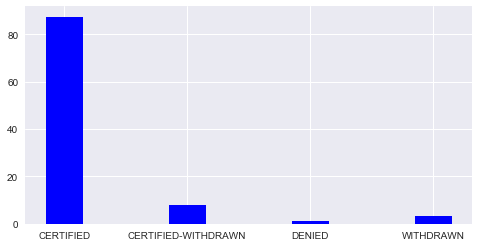

In [7]:
#Percent distribution of data wrt target class
df_copy.groupby('CASE_STATUS').size()*100/df_copy['CASE_NUMBER'].size
plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), df_copy.groupby('CASE_STATUS').size().values*100/df_copy['CASE_NUMBER'].size, color="blue", width=0.3)
plt.xticks(np.arange(4), ['CERTIFIED','CERTIFIED-WITHDRAWN' , 'DENIED', 'WITHDRAWN'])
plt.title='Data distribution wrt target class'
plt.show()

**Observation** - The data is highly skewed in favor of CASE_STATUS = CERTIFIED which makes up close to 90% all training dataset.

**Preprocessing action** - As we know this is real life data, we do not want to change its distribution to make it uniform. However to reduce the skewness a bit, we will consider combining the 3 minority classes - {CERTIFIED-WITHDRAWN,DENIED,WITHDRAWN} into a single class called NOT CERTIFIED. This change will also convert our machine learning problem from a multinomial classification to a binary classification problem.

**Next, lets check if there are any records with VISA CLASS other than H1B or EMPLOYER COUNTRY other than USA**

In [8]:
#Visa class other than H1B?
df_copy.groupby('VISA_CLASS').size()

VISA_CLASS
E-3 Australian      12157
H-1B               610304
H-1B1 Chile           935
H-1B1 Singapore      1254
dtype: int64

In [9]:
#Employer Country other than USA?
df_copy.groupby('EMPLOYER_COUNTRY').size()

EMPLOYER_COUNTRY
AUSTRALIA                        2
CAMBODIA                         1
CANADA                           7
CHINA                            1
UNITED STATES OF AMERICA    528132
dtype: int64

**Observation** - There are some records where VISA CLASS is other than H1B and EMPLOYER COUNTRY is other than USA. The scope of this problem is only to predict LCA outcomes **applicable for H1B visa for US employer**.

**Preprocessing action** - We will need to filter such records that are out of scope of our current problem statement.

**Lets run a statistical description of the training features and plot histograms to understand more about their distribution**

In [10]:
#statistically describe the training dataset
df_copy.describe()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,PREVAILING_WAGE,PW_SOURCE_YEAR,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,PUBLIC_DISCLOSURE_LOCATION
count,624650.000000,624650.000000,624650.000000,624650.000000,624650.000000,624650.000000,624650.000000,6.246490e+05,624605.000000,6.246500e+05,6.246490e+05,0.0
mean,1.893800,0.834251,0.326300,0.130657,0.008979,0.259485,0.332703,7.321117e+04,2016.167059,8.285702e+04,2.416596e+04,NaN
std,4.826703,3.556236,1.243793,0.955791,0.157690,1.095563,1.418231,2.574025e+05,5.128159,4.266316e+04,5.255090e+04,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.682600e+04,2016.000000,6.300000e+04,0.000000e+00,NaN
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.022100e+04,2016.000000,7.600000e+04,0.000000e+00,NaN
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.914900e+04,2017.000000,1.000000e+05,0.000000e+00,NaN
max,155.000000,150.000000,55.000000,50.000000,50.000000,150.000000,50.000000,2.016227e+08,2017.000000,1.688000e+06,3.000000e+06,NaN


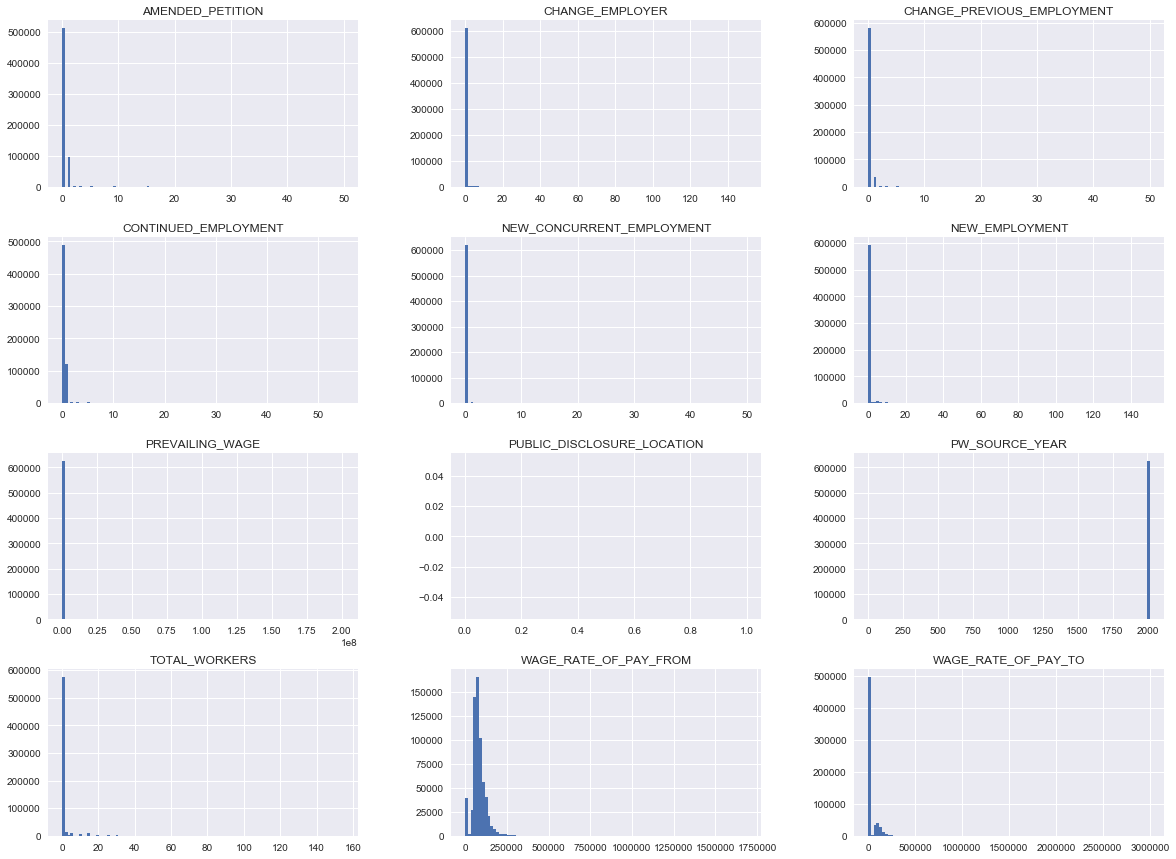

In [11]:
#plot histograms
#expand resultset to view full content
df_copy.hist(bins=100, figsize=(20,15))
plt.show()

**Observation - ** As statistical description is available only for numerical features, we can infer from the above results that majority of the input features are categorical in nature. For those that are numerical, based on the histograms it can be infered that most of them have a limited number of values. The scale is also not uniform.

**Preprocessing action - ** Categorical columns need to be encoded to numerical values. Feature scaling will be needed for numerical columns. 

**As noted earlier, this is a high dimensional input feature set with majority of fields being categorical in nature. To aid feature selection, it is critical to know the completeness of each feature.** We will create a table showing feature type (Categorical/Numerical/Date), number of unique values and % Null counts in the feature.

In [12]:
Input_features=pd.DataFrame(index=df_copy.columns,columns=['Feature type','Number of unique values','% Null counts'])

In [13]:
#Manually compiled list of categorical, numerical and date features based on data inspection
Categorical_features=['CASE_STATUS','VISA_CLASS','EMPLOYER_NAME', 'EMPLOYER_BUSINESS_DBA', 'EMPLOYER_ADDRESS','EMPLOYER_CITY', 'EMPLOYER_STATE', 
 'EMPLOYER_POSTAL_CODE', 'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'AGENT_REPRESENTING_EMPLOYER',
 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE','JOB_TITLE', 'SOC_CODE', 'SOC_NAME', 'NAICS_CODE','NEW_EMPLOYMENT', 
 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT','NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'FULL_TIME_POSITION',
 'PW_UNIT_OF_PAY','PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER','WAGE_UNIT_OF_PAY', 'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR', 
 'SUPPORT_H1B', 'LABOR_CON_AGREE','PUBLIC_DISCLOSURE_LOCATION', 'WORKSITE_CITY', 'WORKSITE_COUNTY','WORKSITE_STATE', 
 'WORKSITE_POSTAL_CODE']
Numerical_features=['CASE_NUMBER', 'TOTAL_WORKERS','PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO']
Date_features=['CASE_SUBMITTED', 'DECISION_DATE','EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE','ORIGINAL_CERT_DATE']

In [14]:
for col in df_copy.columns:
    #Feature type
    if col in Categorical_features:
        Input_features['Feature type'].loc[col]='Categorical'
    elif col in Numerical_features:
        Input_features['Feature type'].loc[col]='Numerical'
    else:
        Input_features['Feature type'].loc[col]='Date'
    #Number of valid values
    Input_features['Number of unique values'].loc[col]=pd.unique(df_copy[col]).size
    #Null counts
    Input_features['% Null counts'].loc[col]=np.round(df_copy[col][pd.isnull(df_copy[col])].size*100/df_copy['CASE_NUMBER'].size,2)

In [15]:
#expand resultset to view full content
Input_features

,Feature type,Number of unique values,% Null counts
CASE_NUMBER,Numerical,624650,0
CASE_STATUS,Categorical,4,0
CASE_SUBMITTED,Date,1323,0
DECISION_DATE,Date,358,0
VISA_CLASS,Categorical,4,0
EMPLOYMENT_START_DATE,Date,1599,0
EMPLOYMENT_END_DATE,Date,1646,0
EMPLOYER_NAME,Categorical,71171,0.01
EMPLOYER_BUSINESS_DBA,Categorical,9442,93.07
EMPLOYER_ADDRESS,Categorical,64379,0


**Observation - ** After studying the above table, it is clear that features with high % of nulls (eg. EMPLOYER_PROVINCE) and Categorical features with high cardinality or redundancy (example EMPLOYER_POSTAL_CODE) can be excluded from the training dataset as they do not have decisive information for our classification model. Keeping them will add in unnecessary noise to the training dataset.

**Preprocessing action - ** Features have missing values that need to be handled. 

**The below list of features can be removed from the training dataset -**

CASE_NUMBER,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,EMPLOYER_CITY,EMPLOYER_COUNTRY,EMPLOYER_PROVINCE,EMPLOYER_PHONE, EMPLOYER_PHONE_EXT,AGENT_REPRESENTING_EMPLOYER,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_CITY,AGENT_ATTORNEY_STATE,JOB_TITLE, PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_TO,SUPPORT_H1B,LABOR_CON_AGREE,PUBLIC_DISCLOSURE_LOCATION,WORKSITE_CITY,WORKSITE_COUNTY, ORIGINAL_CERT_DATE

### Data Preprocessing

Based on observations from EDA, we need to perform some data massaging before it can be used for training a ML model. To make the preprocessing steps reusable and isolated to prevent training data leakage, we will implement a data preprocessing pipeline.
The high level flow chart is as shown in the below diagram

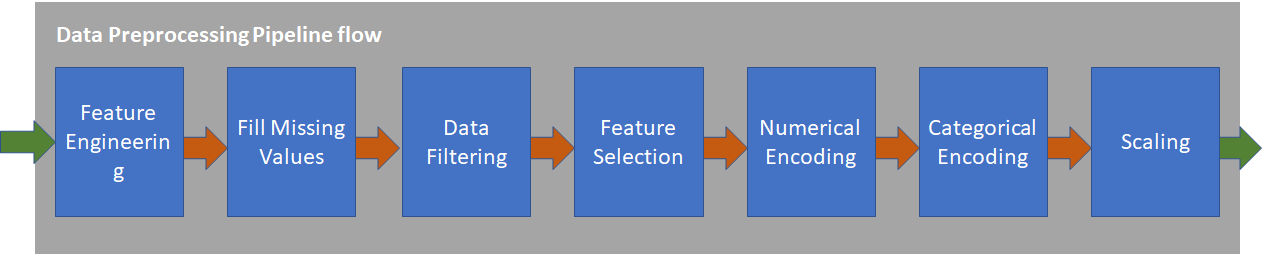

#### Step 1: Feature Engineering
In this step, we enhance the current feature set by adding in some derived features that may provide the ML algorithm additional dimensions of freedom and improve its classification accuracy.
We will derive below 3 new features from the existing training set -

**New feature 1** - Indicator to check if state of employment and state of employer are same?

**New feature 2** - Difference in case submitted and decision date in days, 

**New feature 3** - Duration of employment (difference between employment start and end dates) in days

**Recreate Target field** - We will also convert the target class from a multiclass feature to a binary feature with values = {CERTIFIED,NOT CERTIFIED}

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Feature Engineering class definition
class FeatureEngg(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        #employment duration
        df['EMPLOYMENT_DURATION']=[d.days for d in df['EMPLOYMENT_END_DATE'] - df['EMPLOYMENT_START_DATE']]
        #Decision duration
        df['DECISION_DURATION']=[d.days for d in df['DECISION_DATE'] - df['CASE_SUBMITTED']]
        #same employer and worksite state
        df['SAME_STATE']=[1 if df.EMPLOYER_STATE[i]==df.WORKSITE_STATE[i] else 0 for i in range(df.shape[0])]
        #CASE_STATUS        
        df['TARGET_CLASS']=[0 if df.CASE_STATUS[i]=='CERTIFIED' else 1 for i in range(df.shape[0])]
        return df

#### Step 2: Fill Missing values
As observed in EDA, many fields have missing values that need to be handled. As the feature set is both categorical and numerical, we will complete the feature by ‘front filling’ using the previous valid value of that feature. This is done mainly for categorical variables and dates. Numeric variables do not have any missing values.

In [18]:
class FillMissing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        df=df.fillna(method='pad')
        return df

#### Step 3: Filtering
This step handles the filtering steps to remove data that is out of scope. We will be removing the entire training record for out of scope data.

In [19]:
class DataFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        df = df[df.VISA_CLASS == 'H-1B']
        df = df[df.EMPLOYER_COUNTRY == 'UNITED STATES OF AMERICA']
        
        return df

#### Step 4: Feature Selection
This step will remove features identified as redundant or incomplete during EDA. 

**Note** There will be one more feature selection step during the training phase of ML model where we will use L1 regularization to select only significant features.

In [20]:
#define columns list to drop for pipeline 
cat_columns=['CASE_NUMBER','EMPLOYER_BUSINESS_DBA','EMPLOYER_ADDRESS','EMPLOYER_CITY','EMPLOYER_COUNTRY','EMPLOYER_PROVINCE',
         'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT','AGENT_REPRESENTING_EMPLOYER','AGENT_ATTORNEY_NAME','AGENT_ATTORNEY_CITY',
         'AGENT_ATTORNEY_STATE','JOB_TITLE', 'PW_SOURCE_OTHER','WAGE_RATE_OF_PAY_TO','SUPPORT_H1B','LABOR_CON_AGREE',
         'PUBLIC_DISCLOSURE_LOCATION','WORKSITE_CITY','WORKSITE_COUNTY','ORIGINAL_CERT_DATE','VISA_CLASS','EMPLOYER_POSTAL_CODE',
         'WORKSITE_POSTAL_CODE', 'SOC_NAME','NAICS_CODE','EMPLOYER_NAME','CASE_STATUS']

In [21]:
class ColumnDrop(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        for col in self.columns:
            if col in df.columns:
                del df[col]
        return df

#### Step 5: Numerical Encoding
Dates are ordinal features so to encode them to numeric features, they have been converted to the number of days from the minimum date of each feature. This will also standardize all dates to a single scale.

In [22]:
date_cols=['CASE_SUBMITTED','DECISION_DATE','EMPLOYMENT_START_DATE','EMPLOYMENT_END_DATE']

In [23]:
class Num_Encoding(BaseEstimator, TransformerMixin):
    def __init__(self,date_col):
        self.date_col=date_col
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        for col in date_cols:
            if col in df.columns:
                min_date=np.min(df[col])
                df[col]=[(dte-min_date).days for dte in df[col]]
        #encode SOC code
        df.SOC_CODE=[str.replace(code,'-','').split('.')[0] for code in df.SOC_CODE]  
        return df

#### Step 6: Categorical Encoding
We have implemented label encoding for translating categorical features to corresponding numerical form. 

In [24]:
class Cat_Encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df, y=None):
        return self
    def transform(self,df,y=None):
        #state_list=np.sort(pd.unique(df['EMPLOYER_STATE']))
        #replace_state=np.arange(pd.unique(df['EMPLOYER_STATE']).size)
        col_encode_state=['EMPLOYER_STATE','WORKSITE_STATE']
        for col in col_encode_state:
            if col in df.columns:
                state_list=np.sort(pd.unique(df[col]))
                replace_state=np.arange(pd.unique(df[col]).size)
                df[col].replace(to_replace=state_list,value=replace_state,inplace=True)

        wage_list=np.sort(pd.unique(df['WAGE_UNIT_OF_PAY']))
        replace_wage=np.arange(pd.unique(df['WAGE_UNIT_OF_PAY']).size)
        col_encode_pay=[ 'WAGE_UNIT_OF_PAY','PW_UNIT_OF_PAY']
        for col in col_encode_pay:
            if col in df.columns:
                df[col].replace(to_replace=wage_list,value=replace_wage,inplace=True)
    
        col_encode_other=['H-1B_DEPENDENT','H1B_DEPENDENT','SOC_CODE','PW_WAGE_LEVEL','WILLFUL_VIOLATOR','FULL_TIME_POSITION','PW_SOURCE']
        for col in col_encode_other:
            if col in df.columns:
                df[col].replace(to_replace=np.sort(pd.unique(df[col])),value=np.arange(pd.unique(df[col]).size),inplace=True)  
        
        return df

**We bring all these preprocessing classes together into a preprocessing pipeline that can be reused for training and testing datasets**

In [25]:
#create a pipeline with Feature engineering and preprocessing
FE_preprocess_pipeline= Pipeline([
        ('FE', FeatureEngg()),
        ('FM', FillMissing()),
        ('DF', DataFilter()),
        ('CD', ColumnDrop(cat_columns)),  
        ('NE', Num_Encoding(date_cols)),
        ('CE', Cat_Encoding()),
        ('SC',MinMaxScaler())
    ])

Before proceeding to the next step, we will **execute the data preprocessing pipeline on the training dataset** so it is ready to be consumed by the ML models.

In [26]:
%%time
df_copy=FE_preprocess_pipeline.fit_transform(df_copy)

Wall time: 2min 13s


The target column is still part of our training set and needs to be removed before passing it to the Classifier. We seperate the target class from the input features.

In [27]:
Target_labels=df_copy[:,27]
df_copy=df_copy[:,:27]

### Model Selection

#### ML algorithms evaluated
This is a **binary classification problem** wherein we are trying to predict the output into one of two target class based on 27 input variables. As we already have target class values for training data, we will be applying **supervised learning** algorithms to solve this problem. There are multiple Machine Learning algorithms that can be used for this task and we will be comparing the below algorithms to identify the best one for this problem.

        A.	Decision Tree classifier
        B.	Logistic regression
        C.	Naïve Bayes classifier
        D.	Random Forests
        E.	Linear Discriminant Analysis
        


**Discussion on supervised classifiers not considered for this problem -**
While there are many more good and advanced supervised classification algorithms that could have been considered for this problem, it is important to discuss on why some of the more common ones were not considered in scope of evaluation.

**1. K-NN** - KNN is one of the simplest classification algorithm. However, it has a major drawback that applies our problem. KNN is a non-parametric ML algorithm, and given the large size of training dataset the time taken to validate the model would have been enormous. For this reason it was not considered in scope of evaluation.

**2. SVM ** - SVM is a powerful classifier. It was considered in scope of evaluation initially however the model had a high training time and it was not feasible to include it further due to this.

**3. MLP ** - MLP is a powerful and versatile classifier. Similar to SVM, it was considered in scope of evaluation initially however the model had a high training time and it was not feasible to include it further due to this.

#### Performance metrics 

There is a wide variety of performance metrics available for evaluating classification models and not all will be equally effective in evaluating model for our problem. When we look at our classification problem from performance evaluation perspective, **it is important to consider the heavy bias in the training dataset in favor of one class. So it is extremely important that our model is able to correctly classify the minority class.** In metrics terms, we need the recall for the minority class as high as possible.

For this reason, we will use **F1-score as our performance metric** while evaluating different classifiers.
Accuracy is not helpful in our case because of the bias.

We will also perform a **statistical significance test** to identify if any of the models are significantly different that others. Our intent is to choose the simplest and most efficient model for this classification task.

We will be **using cross fold validation method** to iteratively train each model with the **entire** training dataset and then compare accuracy for them.

In addition to F1-score, we will also be **plotting confusion matrix and classification report for test dataset**. It will provide more insights how well the model fits the data.

In [28]:
#import ML models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action='ignore')

In [29]:
%%time
models = []
models.append(('NB', GaussianNB()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = KFold(n_splits=15, random_state=42)
    cv_results = cross_val_score(model, df_copy, Target_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NB: 0.790341 (0.108881)
LR: 0.588853 (0.239220)
LDA: 0.464587 (0.174834)
CART: 0.585369 (0.180959)
RFC: 0.750475 (0.231982)
Wall time: 11min 51s


**Lets plot the F1 score for each model as a box plot so it is easy to visualize**

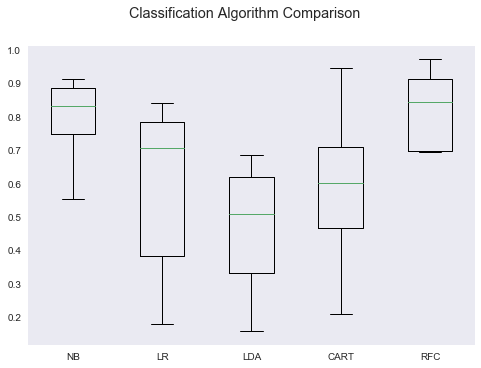

In [30]:
fig = plt.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid()
plt.show()

Naive Bayes and LDA have comparable F1-score scores. 

Let us **perform t-statistic test on RFC, LDA, LR and Naive Bayes** to see if they are statistically similar. In that case, **we will prefer to use Gaussian Naive Bayes as it is a simple algorithm compared to the other two and does not need any hyperparameter tuning**.

We know that **Logistic regression classifier with L1 regularization** can be used effectively for **feature selection**. Instead of using LR model as a classifier, lets use it in the pipeline for feature selection.

#### Statistical Significance test

In [31]:
from scipy import stats
exp_results = pd.DataFrame(columns=["ExpID","Model","Accuracy_Train","t-statistic","p-value"])
i=0
for idx in range(5):
    if i==0:
        exp_results.loc[len(exp_results)]=[len(exp_results)+1,models[idx][0],np.mean(results[0]),0,0]
    else:
        exp_results.loc[len(exp_results)]=[len(exp_results)+1,models[idx][0],np.mean(results[idx]),stats.ttest_rel(results[0], results[idx]).statistic,stats.ttest_rel(results[0], results[idx]).pvalue]
    i+=1
exp_results

,ExpID,Model,Accuracy_Train,t-statistic,p-value
0,1,NB,0.790341,0,0
1,2,LR,0.588853,5.13583,0.000151383
2,3,LDA,0.464587,11.4299,1.7426e-08
3,4,CART,0.585369,4.77787,0.00029457
4,5,RFC,0.750475,0.659599,0.520215


**Observations from t-Statistic test** -
The p-value for RFC is 0.3 which is much higher than the threshold of 0.05 which mean there is no significant difference between RFC and NB models.

We have decided to use LR for our feature selection step. 

Though LDA is significantly different that NB, it is more complex compared to NB and also has a lower F1-score.
**Lets finalize on Naive Bayes as our model of choice** for now and see how it performs on the test dataset. 

Our second choice would be Logistic Regression because we will have a model trained already for feature selection. It is also significantly different that NB.


### Feature selection using Logistic Regression Classifier with L1 regularization
Lets train a logistic regression classifier with L1 regularization on the entire training dataset. This model will act as our feature selector and can be used as the first step to train our selected model with only significant features from the training dataset.


In [32]:
Feature_selector = LogisticRegression(C=10, n_jobs=-1, penalty='l1', random_state=42)

In [33]:
%%time
Feature_selector.fit(df_copy,Target_labels)

Wall time: 1min 55s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

For ease of identifying significant features, lets get a list of features from the dataset. The pipeline converted the input dataframe to an array so we will need to generate the feature list from source.

In [34]:
df_plot=df.columns.values
df_plot=list(filter(lambda x:x not in cat_columns,df_plot))
df_plot=df_plot[:27]

**Lets plot the coefficients of the Feature selection model so the important features in the training dataset can be easily visualized**

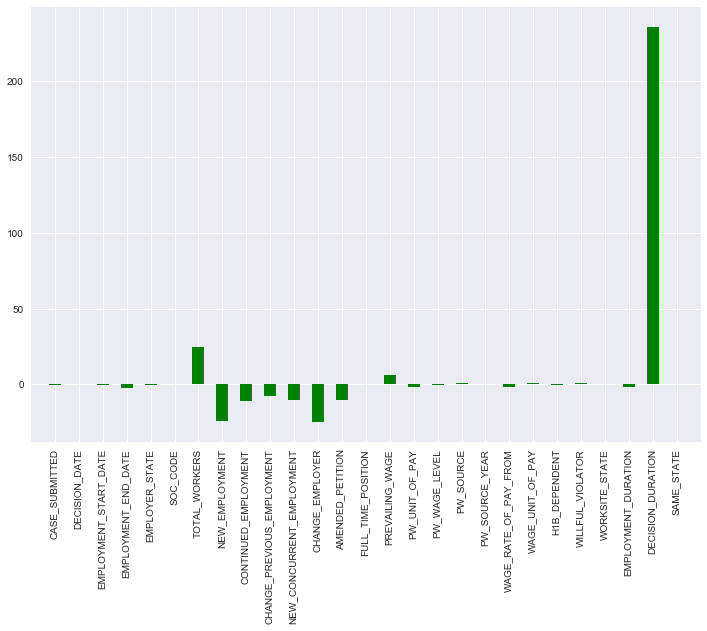

In [35]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(Feature_selector.coef_.shape[1]), Feature_selector.coef_[0],color='green',width=0.5)
plt.xticks(np.arange(Feature_selector.coef_.shape[1]), df_plot, rotation='vertical')
plt.xlim([-1, Feature_selector.coef_.shape[1]])
plt.title="Feature importance for LCA outcome classes"
plt.show()

The plot clearly shows that only 21 features out of 27 have significant information in the training dataset. L1 regularization reduces the coefficients of unimportant features to 0. 

**Interesting Observation - ** 
The derived predictor variable Decision Duration is driving all the classification decisions between class 1 and 0. It is intuitive because according to the training data, applications that take longer period for OFLC to decide have not been Certified.

### ML Model selection and training
Lets create a pipeline that combines the feature selection step and the selected ML model to train on the entire dataset.
We will then use the **SelectModelFrom** class to reuse our trained Logistic Regression model as a feature selector in the pipeline along with the Gaussian Naive Bayes classifier to train only on the most important training features.

In [36]:
from sklearn.feature_selection import SelectFromModel

In [37]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(Feature_selector)),
  ('classification', GaussianNB())
])

In [38]:
%%time
clf.fit(df_copy, Target_labels)

Wall time: 1min 57s


Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        prefit=False, threshold=None)), ('classification', GaussianNB(priors=None))])

Lets predict the F1-score and accuracy of this classification pipeline on training dataset just to understand if there are any obvious problems.

In [39]:
y_pred_train=clf.predict(df_copy)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('F1_score Training dataset:',f1_score(Target_labels,y_pred_train))
print('Accuracy Training dataset:',accuracy_score(Target_labels,y_pred_train))

F1_score Training dataset: 0.838682165211
Accuracy Training dataset: 0.961569279018


### Validate model on test data
We had held out the test data set for validating the classifier. Let us see how our classifier fares when tested on the held out test data.

We will pass the test data through the same preprocesing pipeline so it the classifier gets similar features as it was trained on.

In [41]:
%%time
df_test=FE_preprocess_pipeline.transform(df_test)

Wall time: 19.1 s


The target column is available in the test dataset as well so it needs to be removed.

In [42]:
Target_labels_test=df_test[:,27]
df_test=df_test[:,:27]

Now lets use our model to predict the output for the test data set and find the classification accuracy compared to the true output values

In [43]:
y_pred_test=clf.predict(df_test)

#### F1-Score and Accuracy

In [44]:
f1_fs=f1_score(Target_labels_test,y_pred_test,average=None)
acc_fs=accuracy_score(Target_labels_test,y_pred_test)

In [45]:
print('F1_score Test dataset:',f1_fs)
print('Accuracy Test dataset:',acc_fs)

F1_score Test dataset: [ 0.92749502  0.69237653]
Accuracy Test dataset: 0.882648959951


#### Confusion Matrix
The confusion matrix provides us with the numbers for True Positives, True Negatives, False Positives and False Negatives. These numbers helps us understand in detail what is going on with our model.

In [46]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(Target_labels_test, y_pred_test)

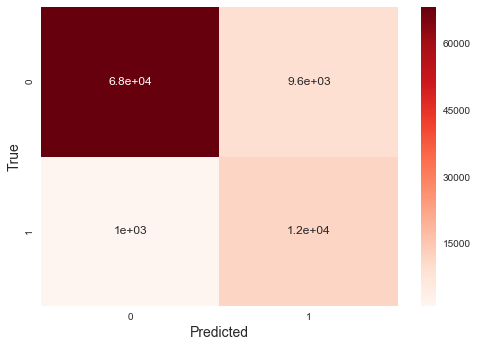

In [47]:
g = sns.heatmap(cm_test, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

#### Classification Report
Classification report will shed more light on the precision and Recall values for each target class. It will help us evaluate our model better.

In [48]:
from sklearn.metrics import classification_report
print('classification_report for testing dataset:')
print(classification_report(Target_labels_test, y_pred_test))

classification_report for testing dataset:
             precision    recall  f1-score   support

        0.0       0.98      0.88      0.93     77781
        1.0       0.55      0.92      0.69     13032

avg / total       0.92      0.88      0.89     90813



#### Observations
The results are pretty good. Let us consolidate the critical observations from the three validation metrics.

1. The **F1-score** is a harmonic mean of Precision and Recall so it does not tell the complete story about classification performance by itself. Our goal was to have a good recall for the Class 1 which is a minority class. The F1-score for Class 0 (CERTIFIED) is 0.92 but it is a bit lower for Class 1 (NOT CERTIFIED). The Accuracy of the model is at a decent 88% for test dataset.  

2. The **Confusion Matrix** plots the comparison of true class observations with predicted class and is a good place to start looking for clues of classification performance. In our case, it is important to focus on the values from the perspective of the minority class (Class=1). The matrix can be translated for CLass 1 as below -

    True positives ~ 12k, False positives ~ 9.6k
    
    True negatives ~ 68k, False negatives ~ 1k
   
3. **Classification report** gives us the metrics for each class separately. As can be seen clearly, Precision and Recall for Class 0, which is majority class, is pretty high and within acceptable performance threshold. For the minority class of 1, the recall is good but the precision is pretty low at 55%. 

**Why is Recall more important than Precision for our problem?**

The recall of 0.92 signifies that for the minority class, our model misclassified only 8% Class 1 records as Class 0. It is really good given that the training and testing data are heavily biased towards majority class. Minority class only had 13-15% representation during training. The model wrongly classifies 12% of majority class records into Class 1 (False Positives for Class 1) but it is still acceptable with this model because the over all precision for class 0 is good.

#### Analysis of alternate model and discussion
**This discission will further support the decision of using recall as the metric instead of precision**

For the sake of our understanding (and to play devil's advocate), let us see how the Logistic Regression model we used for feature importance classified the test data. We will then plot the confusion matrix and Classification report to see the results.

In [49]:
y_pred_test_LR=Feature_selector.predict(df_test)

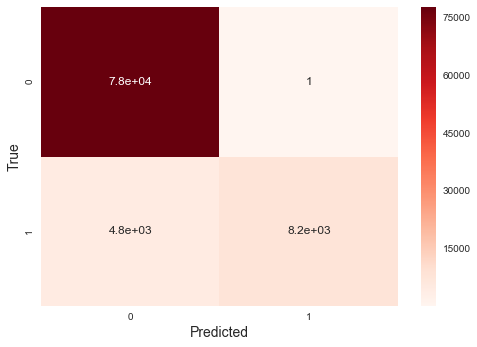

In [50]:
g = sns.heatmap(confusion_matrix(Target_labels_test, y_pred_test_LR), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

In [51]:
print(classification_report(Target_labels_test, y_pred_test_LR))

             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97     77781
        1.0       1.00      0.63      0.77     13032

avg / total       0.95      0.95      0.94     90813



At first look, this model looks much better than our selected model. However on closer inspection, **it is clear that the model is overfitted for majority class due to the bias in training dataset.** The model predicts all class 0 samples correctly and also misclassifies 30% of class 1 samples as class 0. The minority class suffer badly with a recall of just 63%. 

**This is exactly why the emphasis has been placed on accurately classifying the minority class than in achieving high overall precision.**

### Success/Failure Analysis
#### Success 
This has been an interesting project for applying all the machine learning knowledge that I learned over this course. Based on the recall, precision and f1-score values of the classifier on test dataset, it can be said that the selected classifier model is reliable and can successfully classify real life dataset with good precision and accuracy. 

Feature selection, preprocessing and reducing the target class from 4 to 2 greatly helped in the success of this project. Selecting the correct validation metrics were key in defending the model performance and I think the explanations has been given enough justice in the project documentation.

Having tested the project on highly biased real life dataset, I am confident on the classification performance of this model.

#### Challenges 
The main challenges I faced were ML algorithms taking considerable time to train. Especially for MLP and SVC, I was not able to evalute them because of this reason. The data was highly biased and high dimensional. Selecting the right performance metric was crucial and took some deliberation and research.

#### Future Enhancements
This project can be enhanced further by evaluating the performance of more advanced classifiers like SVM, MLP and Random Forest ensemble. 
Further work should also be done on improving the precision score for the minority class which is currently at 55%. The model is underfit for Class 0 and training an ensemble classifier may help in improving the precision.